### Mobile Net

![Untitled](https://viso.ai/wp-content/uploads/2024/04/depthwise.jpg)

Google 의 Howard 의 딥 러닝 아키텍쳐

- Depthwise Separable Convolution 사용
    - 성능 크게 줄지 않고, 속도 빠르고 파러미터 감소
    - 이전 층의 Depth 에 대하여 하나 씩 하나의 필터만 적용하여

- Pointwise Convolution 사용

- 통합 결합
    - 뎁스 와이즈의 필터 적용 결과에서는 모든 채널 정보가 분리되어있어 통합하는 과정이 필요하다.
- 모바일 디바이서 등에서 활용
- 메모리 연산 자원을 적게 이용
    - ResNet 25636712 vs MoblieNet 4253864

In [1]:
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, BatchNormalization, ReLU
from tensorflow.keras.models import Model

input_tensor = Input(shape=(128, 128, 64))

2024-11-01 16:32:14.117016: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730446334.136078    7268 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730446334.141828    7268 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-01 16:32:14.160671: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Depthwise Separable Convolution

- x = Conv2D(1,kernel_size=(3, 3), padding='same')(input_tensor)
- 각 입력 채널에 대해 3x3 크기의 필터를 독립적으로 적용.
- 필터 크기 3x3
- padding='same': 패딩 추가 -> 입력과 출력의 크기를 동일하게 유지 
- depth_multiplier=1: 각 입력 채널에 대해 하나의 필터 적용

In [2]:
# Depthwise Convulution
x = DepthwiseConv2D(kernel_size=(3, 3), padding='same', depth_multiplier=1)(input_tensor)
x = BatchNormalization()(x)
x = ReLU()(x)

I0000 00:00:1730446336.331199    7268 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9711 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:07:00.0, compute capability: 8.6


### PointWise Convolution

In [3]:
# Pointwise Convolution
x = Conv2D(filters=16, kernel_size=(1, 1), padding='same')(x)
# 출력 채널 수 32로 줄이기

x = BatchNormalization()(x)
x = ReLU()(x)

### MoblieNet Pretrained Model

In [4]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

In [9]:
# MobileNet 모델 불러오기 (사전 학습된 가중치 사용)
model = MobileNet(weights='imagenet')
model.summary()

# from tensorflow.keras.utils import plot_model

# plot_model(
#     model,
#     # to_file="model.png",
#     show_shapes=True,
#     show_layer_names=True,
#     rankdir="TB",
#     expand_nested=False,
#     dpi=128,
#     show_layer_activations=False,)

Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 4,253,864 (16.23 MB)

 Trainable params: 4,231,976 (16.14 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [6]:
# 예제 이미지 로드 및 전처리
img_path = '../../data/img_fish.png'  # 사용할 이미지 경로 설정

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)


In [7]:
preds = model(img_array)

I0000 00:00:1730446341.386734    7268 cuda_dnn.cc:529] Loaded cuDNN version 90300


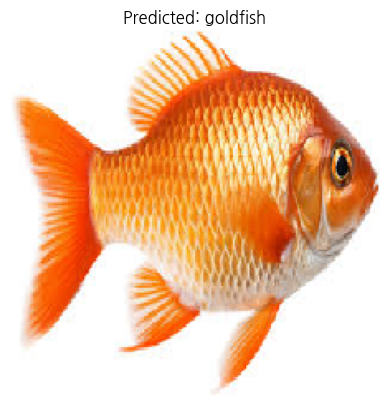

In [8]:

# 이미지 출력 w. 예측 결과
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {decode_predictions(preds, top=1)[0][0][1]}")
plt.show()